#  USAID Sentiment Analysis in Kenya

#  1. Business Understanding

USAID has long played a major role in Kenya’s development — funding health, education, and governance programs. However, recent shifts in US foreign aid policy, including funding cuts and multiple project phaseouts, have sparked growing conversation and concern.

This project focuses on analyzing public and media sentiment **after these cuts or the scaling back of USAID programs**. The goal is to uncover:
- Public reaction to USAID’s funding changes
- Sentiment trends in both news media and online communities
- Common concerns, narratives, or misinformation emerging around USAID

These insights can support government and development stakeholders in understanding ground-level perception and refining their outreach or policy communication.

---

#  2. Data Understanding
## 2.1 Data Collection
We collected data from two main sources:
- **NewsAPI articles** referencing USAID and Kenya 
- **Reddit posts** from relevant subreddits discussing USAID-related topics



### 2.1.1 News Data Collection

### Overview

In [1]:
import pandas as pd
from glob import glob

# --- DIRECTORY PATH ---
data_dir = "../data/raw/news_data/"

# --- GET ALL CSV FILES IN THE DIRECTORY ---
csv_files = glob(data_dir + "*.csv")

# --- LOAD AND DISPLAY SUMMARY ---
news_dfs = {}
for file in csv_files:
    try:
        df = pd.read_csv(file)
        news_dfs[file] = df
        print(f"{file.split('/')[-1]}")
        print(f"   - Rows: {df.shape[0]}, Columns: {df.shape[1]}")
        print(f"   - Columns: {list(df.columns)}\n")
    except Exception as e:
        print(f"❌ Failed to load {file}: {e}")


Agatha_news_fulltext.csv
   - Rows: 562, Columns: 8
   - Columns: ['keyword', 'source', 'author', 'title', 'publishedAt', 'summary', 'text', 'url']

newsapi_usaid_articles.csv
   - Rows: 89, Columns: 6
   - Columns: ['title', 'description', 'url', 'publishedAt', 'source', 'content']

leo_newsapi_articles_enriched.csv
   - Rows: 99, Columns: 8
   - Columns: ['source', 'author', 'title', 'description', 'content', 'url', 'published_at', 'full_text']

Mbego_news_usaid_kenya_fulltext.csv
   - Rows: 24, Columns: 8
   - Columns: ['source', 'author', 'title', 'description', 'url', 'publishedAt', 'summary', 'full_text']

Agatha_news.csv
   - Rows: 592, Columns: 8
   - Columns: ['keyword', 'source', 'author', 'title', 'description', 'content', 'publishedAt', 'url']

ruth_news.csv
   - Rows: 20, Columns: 7
   - Columns: ['Unnamed: 0', 'source', 'title', 'description', 'content', 'url', 'publishedAt']

cecilia.newsapi.csv
   - Rows: 1787, Columns: 9
   - Columns: ['keyword', 'source', 'author', 't

### Collection

In [2]:

# Get all CSV files in the news_data folder
news_files = glob("../data/raw/news_data/*.csv")

# Final columns to keep
final_columns = ['source', 'title', 'description', 'text', 'url', 'keyword', 'published_date']

# List to store clean DataFrames
merged_dfs = []

for file in news_files:
    print(f"Processing: {file.split('/')[-1]}")
    df = pd.read_csv(file)

    # Remove unnamed index columns if any
    df = df.loc[:, ~df.columns.str.contains("^Unnamed")]

    # Determine which text column to use
    if 'full_text' in df.columns:
        df['text'] = df['full_text']
    elif 'text' in df.columns:
        pass  # Use existing 'text'
    else:
        print(f"Skipped (no text/full_text found): {file}")
        continue

    # Drop rows where text is fully missing or blank
    df = df[df['text'].notna() & (df['text'].str.strip() != "")]

    # Rename date columns
    df = df.rename(columns={
        'publishedAt': 'published_date',
        'published_at': 'published_date'
    })

    # Add missing expected columns with None
    for col in final_columns:
        if col not in df.columns:
            df[col] = None

    # Restrict to only the required final columns
    df = df[final_columns]

    # Fill missing keywords
    df['keyword'] = df['keyword'].fillna("Unknown")

    # Convert to datetime
    df['published_date'] = pd.to_datetime(df['published_date'], errors='coerce')

    # Drop rows without title or url (minimal metadata)
    df = df.dropna(subset=['url', 'title'])

    # Add cleaned DataFrame to list
    merged_dfs.append(df)

# Concatenate and deduplicate
combined_df = pd.concat(merged_dfs, ignore_index=True)
combined_df.drop_duplicates(subset='url', inplace=True)

# Save the merged file
combined_df.to_csv("../data/processed/Leo_merged_news_dataset.csv", index=False)
print(f"Merged News dataset saved with shape: {combined_df.shape}")


Processing: Agatha_news_fulltext.csv
Processing: newsapi_usaid_articles.csv
Skipped (no text/full_text found): ../data/raw/news_data/newsapi_usaid_articles.csv
Processing: leo_newsapi_articles_enriched.csv
Processing: Mbego_news_usaid_kenya_fulltext.csv
Processing: Agatha_news.csv
Skipped (no text/full_text found): ../data/raw/news_data/Agatha_news.csv
Processing: ruth_news.csv
Skipped (no text/full_text found): ../data/raw/news_data/ruth_news.csv
Processing: cecilia.newsapi.csv
Skipped (no text/full_text found): ../data/raw/news_data/cecilia.newsapi.csv
Processing: Mbego_news_usaid_kenya_recent.csv
Skipped (no text/full_text found): ../data/raw/news_data/Mbego_news_usaid_kenya_recent.csv
Merged News dataset saved with shape: (471, 7)


### 2.1.2 Reddit Data Collection
### Overview

In [3]:
# Get all Reddit CSVs from folder
reddit_files = glob("../data/raw/reddit_data/*.csv")

# Display shape and columns of each
reddit_dfs = {}
for file in reddit_files:
    try:
        df = pd.read_csv(file)
        reddit_dfs[file] = df
        print(f"{file.split('/')[-1]}")
        print(f"   - Rows: {df.shape[0]}, Columns: {df.shape[1]}")
        print(f"   - Columns: {list(df.columns)}\n")
    except Exception as e:
        print(f"Failed to load {file}: {e}")


reddit_usaid_sentiment.csv
   - Rows: 17, Columns: 7
   - Columns: ['subreddit', 'title', 'score', 'url', 'created_utc', 'num_comments', 'selftext']

Mbego_reddit_usaid_kenya2.csv
   - Rows: 163, Columns: 6
   - Columns: ['title', 'score', 'url', 'created', 'subreddit', 'selftext']

Mbego_reddit_usaid_kenya.csv
   - Rows: 17, Columns: 6
   - Columns: ['title', 'score', 'url', 'created', 'subreddit', 'selftext']

cecilia.redditsubs.csv
   - Rows: 247, Columns: 9
   - Columns: ['subreddit', 'keyword', 'title', 'text', 'date_posted', 'upvotes', 'comments', 'url', 'permalink']

leo_reddit_posts.csv
   - Rows: 150, Columns: 10
   - Columns: ['subreddit', 'search_term', 'title', 'text', 'created_utc', 'created_date', 'score', 'num_comments', 'permalink', 'url']

cecilia.reddit_nbo_ke_africa.csv
   - Rows: 29, Columns: 9
   - Columns: ['subreddit', 'keyword', 'title', 'text', 'date_posted', 'upvotes', 'comments', 'url', 'permalink']

reddit_usaid_kenya.csv
   - Rows: 17, Columns: 6
   - Colum

In [4]:
# Get all Reddit CSV files
reddit_files = glob("../data/raw/reddit_data/*.csv")

# Final columns to standardize
final_columns = ['subreddit', 'title', 'text', 'url', 'created_date', 'keyword']

# Store cleaned DataFrames
merged_dfs = []

for file in reddit_files:
    print(f"Processing: {file.split('/')[-1]}")
    df = pd.read_csv(file)

    # Drop any unnamed index column
    df = df.loc[:, ~df.columns.str.contains("^Unnamed")]

    # Normalize relevant columns
    df = df.rename(columns={
        'selftext': 'text',
        'search_term': 'keyword',
        'date_posted': 'created_date',
        'created': 'created_date'
    })

    # Handle created_utc if present
    if 'created_utc' in df.columns:
        df['created_utc'] = pd.to_datetime(df['created_utc'], unit='s', errors='coerce')
        df['created_date'] = df['created_utc']

    # Skip file if neither 'text' nor 'selftext' present
    if 'text' not in df.columns or df['text'].isna().all():
        print(f"Skipped (no usable text): {file.split('/')[-1]}")
        continue

    # Keep only final columns (fill missing ones with None)
    for col in final_columns:
        if col not in df.columns:
            df[col] = None

    df = df[final_columns]

    # Filter out rows with missing or empty text
    df = df[df['text'].notna() & (df['text'].str.strip() != "")]

    # Fill missing keywords
    df['keyword'] = df['keyword'].fillna("Unknown")

    # Parse dates safely
    df['created_date'] = pd.to_datetime(df['created_date'], errors='coerce')

    # Optional: Keep rows even if title or url are missing (for exploratory flexibility)
    merged_dfs.append(df)

# Merge and deduplicate
combined_df = pd.concat(merged_dfs, ignore_index=True)
combined_df.drop_duplicates(subset='url', inplace=True)

# Save cleaned dataset
combined_df.to_csv("../data/processed/Leo_merged_reddit_dataset.csv", index=False)
print(f"Merged Reddit dataset saved with shape: {combined_df.shape}")


Processing: reddit_usaid_sentiment.csv
Processing: Mbego_reddit_usaid_kenya2.csv
Processing: Mbego_reddit_usaid_kenya.csv
Processing: cecilia.redditsubs.csv
Processing: leo_reddit_posts.csv
Processing: cecilia.reddit_nbo_ke_africa.csv
Processing: reddit_usaid_kenya.csv
Processing: Agatha_reddit.csv
Processing: ruth_reddit.csv
Merged Reddit dataset saved with shape: (542, 6)


## 2.1.3 Unified Data Collection

- The group agreed on joint datasets in the `data/processed/news_data` and the `data/processed/reddit_data`subfolders


In [5]:
reddit_data = pd.read_csv('../data/processed/reddit_data/reddit_data.csv')
news_data = pd.read_csv('../data/processed/news_data/news_data.csv')

### 2.1.4 Data Overview

In [6]:
# Function to check data overview
def data_overview(df):
    print(f"The dataset has {df.shape[0]} rows and {df.shape[1]} columns\n")
    display(df.info())
    print( "\n---Missing Values---\n")
    display(df.isna().sum())
    print( "\n---Sample---\n")
    display(df.head())


### News Overview

In [7]:
data_overview(news_data)

The dataset has 2549 rows and 7 columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2549 entries, 0 to 2548
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   title           2549 non-null   object
 1   description     2533 non-null   object
 2   text            2524 non-null   object
 3   url             2547 non-null   object
 4   keyword         2379 non-null   object
 5   published_date  2450 non-null   object
 6   source_file     2549 non-null   object
dtypes: object(7)
memory usage: 139.5+ KB


None


---Missing Values---



title               0
description        16
text               25
url                 2
keyword           170
published_date     99
source_file         0
dtype: int64


---Sample---



,title,description,text,url,keyword,published_date,source_file
0,Has DOGE really saved the US government $180bn?,Elon Musk first claimed the department would m...,President Donald Trump and adviser Elon Musk c...,https://www.aljazeera.com/news/2025/6/6/has-do...,usaid kenya,2025-06-06,Agatha_news.csv
1,The Life Story of Ecomobilus Technologies Limi...,By Prof Geoffrey Gitau Here is a story showcas...,By Prof Geoffrey Gitau\r\nHere is a story show...,https://cleantechnica.com/2025/05/26/the-life-...,usaid kenya,2025-05-26,Agatha_news.csv
2,"Death, Sexual Violence and Human Trafficking: ...",by Brett Murphy and Anna Maria Barry-Jester \n...,ProPublica is a nonprofit newsroom that invest...,https://www.propublica.org/article/trump-usaid...,usaid kenya,2025-05-28,Agatha_news.csv
3,Congress Should Quickly Approve Trump’s Rescis...,President Donald Trump‘s rescission legislatio...,President Donald Trumps rescission legislation...,https://www.dailysignal.com/2025/06/10/congres...,usaid kenya,2025-06-10,Agatha_news.csv
4,Food Safety Depends On Every Link In The Suppl...,Almost 1 in 10 people globally fall ill from c...,Colorful fish and vegetables can be purchased ...,https://www.forbes.com/sites/daniellenierenber...,usaid kenya,2025-06-06,Agatha_news.csv


### News Dataset Summary

The merged news dataset contains **2,549 articles** with 7 columns. Most records have complete `title`, `url`, and `text` fields, which are essential for sentiment analysis. However, there are a few missing values in `description`, `keyword`, and `published_date`.

- The `text` column is mostly intact, with only 25 missing entries (less than 1%), making the dataset suitable for text-based analysis.
- The `keyword` field is somewhat sparse but can be filled later through data engineering if needed.
- The source file column is retained for traceability, in case we need to trace back quality or source bias.

This dataset is rich enough for sentiment and thematic analysis on media coverage surrounding USAID in Kenya.


### Reddit Overview

In [8]:
data_overview(reddit_data)

The dataset has 1289 rows and 15 columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1289 entries, 0 to 1288
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   title         1289 non-null   object 
 1   selftext      901 non-null    object 
 2   subreddit     1289 non-null   object 
 3   author        466 non-null    object 
 4   created_utc   1013 non-null   object 
 5   created_date  150 non-null    object 
 6   score         1013 non-null   float64
 7   num_comments  833 non-null    float64
 8   keyword       742 non-null    object 
 9   search_term   150 non-null    object 
 10  date_posted   276 non-null    object 
 11  upvotes       276 non-null    float64
 12  comments      276 non-null    float64
 13  url           1289 non-null   object 
 14  permalink     426 non-null    object 
dtypes: float64(4), object(11)
memory usage: 151.2+ KB


None


---Missing Values---



title              0
selftext         388
subreddit          0
author           823
created_utc      276
created_date    1139
score            276
num_comments     456
keyword          547
search_term     1139
date_posted     1013
upvotes         1013
comments        1013
url                0
permalink        863
dtype: int64


---Sample---



,title,selftext,subreddit,author,created_utc,created_date,score,num_comments,keyword,search_term,date_posted,upvotes,comments,url,permalink
0,"USAID left a month ago, do we have ARVs in Kenya?",Someone on a different group (different websit...,Kenya,muerki,2025-04-15 13:16:53,NaN,3.0,5.0,usaid kenya,NaN,NaN,NaN,NaN,https://www.reddit.com/r/Kenya/comments/1jzrn2...,NaN
1,Classism in r/Kenya and r/nairobi,The classism I'm seeing in both subs is a good...,Kenya,Morio_anzenza,2025-04-07 04:21:12,NaN,169.0,95.0,usaid kenya,NaN,NaN,NaN,NaN,https://www.reddit.com/r/Kenya/comments/1jtcvb...,NaN
2,EX-USAID people!! Let's talk,Are you still in contact with the organisation...,Kenya,vindtar,2025-04-05 19:09:10,NaN,2.0,2.0,usaid kenya,NaN,NaN,NaN,NaN,https://www.reddit.com/r/Kenya/comments/1jsb14...,NaN
3,Why western powers back Israel no matter what ...,"I don't care what good book you read, but it's...",Kenya,Gold_Smart,2025-03-25 08:18:04,NaN,13.0,20.0,usaid kenya,NaN,NaN,NaN,NaN,https://www.reddit.com/r/Kenya/comments/1jjehw...,NaN
4,Is kenya capable of funding its needs now that...,How is kenya prepared to fill the vacuum of US...,Kenya,westmaxia,2025-03-08 08:08:58,NaN,1.0,6.0,usaid kenya,NaN,NaN,NaN,NaN,https://www.reddit.com/r/Kenya/comments/1j6cjz...,NaN


### Reddit Dataset Summary

The merged Reddit dataset contains **1,289 posts** and 15 columns. The dataset includes metadata such as `subreddit`, `author`, `score`, and `num_comments`, which can provide context beyond the post content.

- The main text content comes from the `selftext` field, which has **388 missing values**, meaning about 70% of posts have usable body content.
- Timestamp data is spread across `created_utc`, `created_date`, and `date_posted` with some sparsity — useful for temporal sentiment trends if cleaned carefully.
- Several fields like `author`, `keyword`, `search_term`, and engagement metrics (`upvotes`, `comments`) have missing values but can be optionally used depending on the analytical direction.

Despite sparsity in some fields, this dataset captures a wide range of public sentiment and discourse related to USAID, especially useful for assessing grassroots reactions after funding changes.


#  3. Data Cleaning
- The raw  **news** and **reddit** data shall now be cleaned to a more structured and consitent format before insights could be drawn

# 3.1 News Data Cleaning


In [9]:

print(f"Shape before data cleaning dropping duplicates ->_{news_data.shape}")


Shape before data cleaning dropping duplicates ->_(2549, 7)


In [10]:
import numpy as np
import re
from newspaper import Article
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Enable tqdm for pandas
tqdm.pandas()

# --- 1. Drop Duplicates (full and by URL and text) ---
news_data = news_data.drop_duplicates()
news_data = news_data.drop_duplicates(subset='url')
news_data = news_data.drop_duplicates(subset='text')


# --- 2. Fix Date Format (but don't drop future/missing dates) ---
news_data['published_date'] = pd.to_datetime(news_data['published_date'], errors='coerce')

# --- 3. Extract Full Text using Newspaper3k ---
def extract_full_text(url):
    try:
        article = Article(url)
        article.download()
        article.parse()
        return article.text
    except:
        return np.nan

# Apply extraction (slow process; tqdm gives progress bar)
news_data['full_text'] = news_data['url'].progress_apply(extract_full_text)

# --- 5. Remove rows where full_text is missing or empty ---
news_data['full_text'] = news_data['full_text'].astype(str).str.strip()
news_data = news_data.dropna(subset= ["full_text"])

# --- 6. Clean and Normalize Text ---
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r"http\S+|www\S+|https\S+", '', text)
    text = re.sub(r"<.*?>", '', text)
    text = re.sub(r"[@#]\w+", '', text)
    text = re.sub(r"[^a-z0-9\s\.,!?'\"]", '', text)
    text = re.sub(r"\s+", ' ', text).strip()
    return text

news_data['full_text'] = news_data['full_text'].apply(clean_text)

# --- 7. Fill Missing Values in Other Columns ---
cols_to_fill = ['title', 'keyword', 'published_date']
for col in cols_to_fill:
    if news_data[col].dtype == 'O':
        news_data[col] = news_data[col].fillna("Unknown")
    else:
        news_data[col] = news_data[col].fillna(pd.NaT)

# --- 8. Create Kenya Mention Indicator ---
news_data['mentions_kenya'] = news_data['full_text'].str.contains(r'\bkenya\b', case=False, na=False)

# --- 9. Drop Unneeded Columns ---
news_data = news_data.drop(columns=['text', 'description', 'source_file', 'url'])

# --- 10. Overview ---
data_overview(news_data)

# --- 11. Saving ---
news_data.to_csv("../data/processed/individual datasets/leo_news_unified_cleaned_data.csv")

100%|█████████▉| 1390/1393 [40:49<00:06,  2.23s/it] Building prefix dict from /home/leo/anaconda3/envs/learn-env/lib/python3.8/site-packages/jieba/dict.txt ...
Dumping model to file cache /tmp/jieba.cache
Loading model cost 1.6731600761413574 seconds.
Prefix dict has been built succesfully.
100%|██████████| 1393/1393 [40:59<00:00,  1.77s/it]


The dataset has 1393 rows and 5 columns

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1393 entries, 0 to 2517
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   title           1393 non-null   object        
 1   keyword         1393 non-null   object        
 2   published_date  1319 non-null   datetime64[ns]
 3   full_text       1393 non-null   object        
 4   mentions_kenya  1393 non-null   bool          
dtypes: bool(1), datetime64[ns](1), object(3)
memory usage: 55.8+ KB


None


---Missing Values---



title              0
keyword            0
published_date    74
full_text          0
mentions_kenya     0
dtype: int64


---Sample---



,title,keyword,published_date,full_text,mentions_kenya
0,Has DOGE really saved the US government $180bn?,usaid kenya,2025-06-06,elon musk first claimed the department of gove...,True
1,The Life Story of Ecomobilus Technologies Limi...,usaid kenya,2025-05-26,by prof geoffrey gitau here is a story showcas...,True
2,"Death, Sexual Violence and Human Trafficking: ...",usaid kenya,2025-05-28,"malawis sprawling dzaleka refugee camp, home t...",True
3,Congress Should Quickly Approve Trump’s Rescis...,usaid kenya,2025-06-10,president donald trumps rescission legislation...,True
4,Food Safety Depends On Every Link In The Suppl...,usaid kenya,2025-06-06,nan,False


6

# 3.1 Reddit Data Cleaning

In [11]:
data_overview(reddit_data)

The dataset has 1289 rows and 15 columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1289 entries, 0 to 1288
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   title         1289 non-null   object 
 1   selftext      901 non-null    object 
 2   subreddit     1289 non-null   object 
 3   author        466 non-null    object 
 4   created_utc   1013 non-null   object 
 5   created_date  150 non-null    object 
 6   score         1013 non-null   float64
 7   num_comments  833 non-null    float64
 8   keyword       742 non-null    object 
 9   search_term   150 non-null    object 
 10  date_posted   276 non-null    object 
 11  upvotes       276 non-null    float64
 12  comments      276 non-null    float64
 13  url           1289 non-null   object 
 14  permalink     426 non-null    object 
dtypes: float64(4), object(11)
memory usage: 151.2+ KB


None


---Missing Values---



title              0
selftext         388
subreddit          0
author           823
created_utc      276
created_date    1139
score            276
num_comments     456
keyword          547
search_term     1139
date_posted     1013
upvotes         1013
comments        1013
url                0
permalink        863
dtype: int64


---Sample---



,title,selftext,subreddit,author,created_utc,created_date,score,num_comments,keyword,search_term,date_posted,upvotes,comments,url,permalink
0,"USAID left a month ago, do we have ARVs in Kenya?",Someone on a different group (different websit...,Kenya,muerki,2025-04-15 13:16:53,NaN,3.0,5.0,usaid kenya,NaN,NaN,NaN,NaN,https://www.reddit.com/r/Kenya/comments/1jzrn2...,NaN
1,Classism in r/Kenya and r/nairobi,The classism I'm seeing in both subs is a good...,Kenya,Morio_anzenza,2025-04-07 04:21:12,NaN,169.0,95.0,usaid kenya,NaN,NaN,NaN,NaN,https://www.reddit.com/r/Kenya/comments/1jtcvb...,NaN
2,EX-USAID people!! Let's talk,Are you still in contact with the organisation...,Kenya,vindtar,2025-04-05 19:09:10,NaN,2.0,2.0,usaid kenya,NaN,NaN,NaN,NaN,https://www.reddit.com/r/Kenya/comments/1jsb14...,NaN
3,Why western powers back Israel no matter what ...,"I don't care what good book you read, but it's...",Kenya,Gold_Smart,2025-03-25 08:18:04,NaN,13.0,20.0,usaid kenya,NaN,NaN,NaN,NaN,https://www.reddit.com/r/Kenya/comments/1jjehw...,NaN
4,Is kenya capable of funding its needs now that...,How is kenya prepared to fill the vacuum of US...,Kenya,westmaxia,2025-03-08 08:08:58,NaN,1.0,6.0,usaid kenya,NaN,NaN,NaN,NaN,https://www.reddit.com/r/Kenya/comments/1j6cjz...,NaN


In [ ]:
# show progress bar
tqdm.pandas()



# --- 1: Date Handling ---
# Convert all date columns to datetime
reddit_data['created_utc_dt'] = pd.to_datetime(reddit_data['created_utc'], errors='coerce', utc=True)
reddit_data['created_date_dt'] = pd.to_datetime(reddit_data['created_date'], errors='coerce', utc =True)
reddit_data['date_posted_dt'] = pd.to_datetime(reddit_data['date_posted'], errors='coerce')

# Merge all into a single consistent 'created_date' field
reddit_data['created_date'] = (
    reddit_data['created_utc_dt']
    .fillna(reddit_data['created_date_dt'])
    .fillna(reddit_data['date_posted_dt'])
)

# Flag future-dated posts
reddit_data['is_future_date'] = reddit_data['created_date'] > pd.Timestamp.now(tz='UTC')

# --- 2: Text Handling ---

# Use newspaper3k to fill in missing selftext from URL
def fetch_article_text(url):
    try:
        article = Article(url)
        article.download()
        article.parse()
        return article.text
    except:
        return np.nan

# Fill missing or very short selftext
mask_missing_text = reddit_data['selftext'].isna() | (reddit_data['selftext'].str.strip().str.len() < 20)
reddit_data.loc[mask_missing_text, 'selftext'] = reddit_data.loc[mask_missing_text, 'url'].progress_apply(fetch_article_text)

# Re-clean after fill
reddit_data['selftext'] = reddit_data['selftext'].astype(str)
reddit_data = reddit_data[reddit_data['selftext'].str.strip().astype(bool)]
reddit_data = reddit_data[reddit_data['selftext'].str.split().str.len() >= 3]
reddit_data['selftext'] = reddit_data['selftext'].apply(clean_text)

# --- 3: Drop duplicates by URL ---
reddit_data = reddit_data.drop_duplicates(subset=['url'])

# --- 4: Fill missing keywords ---
reddit_data['keyword'] = reddit_data['keyword'].fillna("unknown")

# --- 5: Rename and drop unnecessary columns ---
reddit_data = reddit_data.rename(columns={'selftext': 'text'})
columns_to_drop = [
    'author', 'created_utc', 'created_date_dt', 'date_posted', 'search_term',
    'score', 'num_comments', 'upvotes', 'comments', 'permalink', 'created_utc_dt', 'date_posted_dt', 'url'
]
reddit_data = reddit_data.drop(columns=columns_to_drop, errors='ignore')

# --- 6. Rename date for uniformity ---
reddit_data = reddit_data.rename(columns={'created_date' : 'published_date'})

# --- 7. Overview ---
data_overview(reddit_data)

# --- 8. Saving ---
reddit_data.to_csv("../data/processed/individual datasets/leo_reddit_unified_cleaned_data.csv")

100%|██████████| 398/398 [15:24<00:00,  2.32s/it]  


The dataset has 737 rows and 6 columns

<class 'pandas.core.frame.DataFrame'>
Int64Index: 737 entries, 0 to 1288
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype              
---  ------          --------------  -----              
 0   title           737 non-null    object             
 1   text            737 non-null    object             
 2   subreddit       737 non-null    object             
 3   created_date    736 non-null    datetime64[ns, UTC]
 4   keyword         737 non-null    object             
 5   is_future_date  737 non-null    bool               
dtypes: bool(1), datetime64[ns, UTC](1), object(4)
memory usage: 35.3+ KB


None


---Missing Values---



title             0
text              0
subreddit         0
created_date      1
keyword           0
is_future_date    0
dtype: int64


---Sample---



,title,text,subreddit,created_date,keyword,is_future_date
0,"USAID left a month ago, do we have ARVs in Kenya?",someone on a different group different website...,Kenya,2025-04-15 13:16:53+00:00,usaid kenya,False
1,Classism in r/Kenya and r/nairobi,the classism i'm seeing in both subs is a good...,Kenya,2025-04-07 04:21:12+00:00,usaid kenya,False
2,EX-USAID people!! Let's talk,are you still in contact with the organisation...,Kenya,2025-04-05 19:09:10+00:00,usaid kenya,False
3,Why western powers back Israel no matter what ...,"i don't care what good book you read, but it's...",Kenya,2025-03-25 08:18:04+00:00,usaid kenya,False
4,Is kenya capable of funding its needs now that...,how is kenya prepared to fill the vacuum of us...,Kenya,2025-03-08 08:08:58+00:00,usaid kenya,False


In [22]:
data_overview(reddit_data)

The dataset has 737 rows and 6 columns

<class 'pandas.core.frame.DataFrame'>
Int64Index: 737 entries, 0 to 1288
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype              
---  ------          --------------  -----              
 0   title           737 non-null    object             
 1   text            737 non-null    object             
 2   subreddit       737 non-null    object             
 3   published_date  736 non-null    datetime64[ns, UTC]
 4   keyword         737 non-null    object             
 5   is_future_date  737 non-null    bool               
dtypes: bool(1), datetime64[ns, UTC](1), object(4)
memory usage: 35.3+ KB


None


---Missing Values---



title             0
text              0
subreddit         0
published_date    1
keyword           0
is_future_date    0
dtype: int64


---Sample---



,title,text,subreddit,published_date,keyword,is_future_date
0,"USAID left a month ago, do we have ARVs in Kenya?",someone on a different group different website...,Kenya,2025-04-15 13:16:53+00:00,usaid kenya,False
1,Classism in r/Kenya and r/nairobi,the classism i'm seeing in both subs is a good...,Kenya,2025-04-07 04:21:12+00:00,usaid kenya,False
2,EX-USAID people!! Let's talk,are you still in contact with the organisation...,Kenya,2025-04-05 19:09:10+00:00,usaid kenya,False
3,Why western powers back Israel no matter what ...,"i don't care what good book you read, but it's...",Kenya,2025-03-25 08:18:04+00:00,usaid kenya,False
4,Is kenya capable of funding its needs now that...,how is kenya prepared to fill the vacuum of us...,Kenya,2025-03-08 08:08:58+00:00,usaid kenya,False


In [13]:
import pandas as pd
news_data = pd.read_csv("../data/processed/individual datasets/leo_news_unified_cleaned_data.csv", index_col= False)
reddit_data = pd.read_csv("../data/processed/individual datasets/leo_reddit_unified_cleaned_data.csv", index_col = False)

## Remove articles unable to be extracted from `newspaper3k`

In [14]:
# Flagging potentially invalid/too-short news articles
news_data['word_count'] = news_data['full_text'].apply(lambda x: len(str(x).split()))

# Flag articles with very short text (< 30 words)
short_articles = news_data[news_data['word_count'] < 30]
news_data = news_data[news_data['word_count'] >= 30]

print(f"Number of news articles dropped: {len(short_articles)}")

Number of news articles dropped: 244


### English Translations

In [15]:
news_data.columns, reddit_data.columns

(Index(['Unnamed: 0', 'title', 'keyword', 'published_date', 'full_text',
        'mentions_kenya', 'word_count'],
       dtype='object'),
 Index(['Unnamed: 0', 'title', 'text', 'subreddit', 'created_date', 'keyword',
        'is_future_date'],
       dtype='object'))

In [16]:
import pandas as pd
from tqdm import tqdm
from langid import classify
from deep_translator import GoogleTranslator

tqdm.pandas()

# --- Language Detection ---
def detect_language(text):
    try:
        lang, _ = classify(text)
        return lang
    except:
        return 'error'

# --- Translation with Caching ---
translation_cache = {}

def translate_to_english(text, detected_lang):
    if detected_lang == 'en' or detected_lang == 'error':
        return text
    if text in translation_cache:
        return translation_cache[text]
    try:
        translated = GoogleTranslator(source=detected_lang, target='en').translate(text)
        translation_cache[text] = translated
        return translated
    except:
        return text

# --- Apply to NewsData ---
print("Detecting language for NewsData...")
news_data['language'] = news_data['full_text'].astype(str).progress_apply(detect_language)

print("Translating NewsData to English...")
news_data['full_text_translated'] = news_data.progress_apply(
    lambda row: translate_to_english(row['full_text'], row['language']), axis=1)

# --- Apply to RedditData ---
print("Detecting language for RedditData...")
reddit_data['language'] = reddit_data['text'].astype(str).progress_apply(detect_language)

print("Translating RedditData to English...")
reddit_data['text_translated'] = reddit_data.progress_apply(
    lambda row: translate_to_english(row['text'], row['language']), axis=1)


/home/leo/anaconda3/envs/learn-env/lib/python3.8/site-packages/tqdm/std.py:697: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel
  0%|          | 0/1149 [00:00<?, ?it/s]

Detecting language for NewsData...


  0%|          | 0/1149 [00:00<?, ?it/s]

Translating NewsData to English...


  2%|▏         | 12/737 [00:00<00:06, 118.06it/s]

Detecting language for RedditData...


  0%|          | 0/737 [00:00<?, ?it/s]

Translating RedditData to English...


100%|██████████| 737/737 [00:06<00:00, 108.09it/s]


## Drop short news articles


# EDA
## 4.1 Set Up 

In [17]:
## Set up

import seaborn as sns
import matplotlib.pyplot as plt

# Set Seaborn style
sns.set_theme(style="whitegrid", palette="deep", font_scale=1.1)

# Optional: Adjust matplotlib parameters
plt.rcParams['figure.figsize'] = (15, 6)
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.labelsize'] = 14


## 4.2 Basic Structure and Distribution


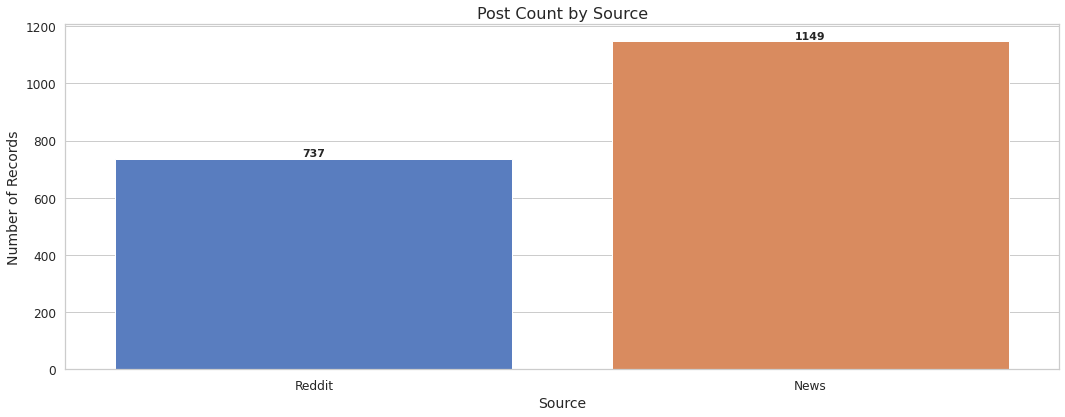

In [41]:
# Make copies of dfs
reddit_data_copy = reddit_data.copy()
news_data_copy = news_data.copy()

# Make columns uniform  
reddit_data_copy
news_data_copy = news_data_copy.rename(columns={'full_text_translated': 'text'})

reddit_data_copy['text'] = reddit_data_copy['text_translated']

# Add a 'source' column to each
reddit_data_copy['source'] = 'Reddit'
news_data_copy['source'] = 'News'

# Combine the two datasets
df_comparison = pd.concat([reddit_data_copy, news_data_copy], ignore_index=True)

# Plot
ax = sns.countplot(data=df_comparison, x='source', palette='muted')

# Add numbers above bars
for p in ax.patches:
    height = int(p.get_height())
    ax.annotate(f'{height}', 
                (p.get_x() + p.get_width() / 2., height), 
                ha='center', va='bottom', fontsize=11, fontweight='bold')

# Final plot adjustments
plt.title('Post Count by Source')
plt.xlabel('Source')
plt.ylabel('Number of Records')
plt.tight_layout()
plt.savefig('/home/leo/Images/Post Count by Source.png')
plt.show()


In [59]:
df_comparison.to_csv('/home/leo/Images/df_comparison.csv')

In [26]:
df_comparison.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1886 entries, 0 to 1885
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Unnamed: 0       1886 non-null   int64  
 1   title            1886 non-null   object 
 2   text             1885 non-null   object 
 3   subreddit        737 non-null    object 
 4   created_date     736 non-null    object 
 5   keyword          1886 non-null   object 
 6   is_future_date   737 non-null    object 
 7   language         1886 non-null   object 
 8   text_translated  736 non-null    object 
 9   source           1886 non-null   object 
 10  published_date   1089 non-null   object 
 11  full_text        1149 non-null   object 
 12  mentions_kenya   1149 non-null   object 
 13  word_count       1149 non-null   float64
 14  char_count       1885 non-null   float64
dtypes: float64(2), int64(1), object(12)
memory usage: 221.1+ KB


In [23]:
df_comparison.columns

Index(['Unnamed: 0', 'title', 'text', 'subreddit', 'created_date', 'keyword',
       'is_future_date', 'language', 'text_translated', 'source',
       'published_date', 'full_text', 'mentions_kenya', 'word_count',
       'char_count'],
      dtype='object')

In [24]:
news_data_copy.columns

Index(['Unnamed: 0', 'title', 'keyword', 'published_date', 'full_text',
       'mentions_kenya', 'word_count', 'language', 'text', 'source'],
      dtype='object')

In [25]:
reddit_data_copy.columns

Index(['Unnamed: 0', 'title', 'text', 'subreddit', 'created_date', 'keyword',
       'is_future_date', 'language', 'text_translated', 'source'],
      dtype='object')

## 4.3 Distribution of Post/Article length according to source
### Histogram

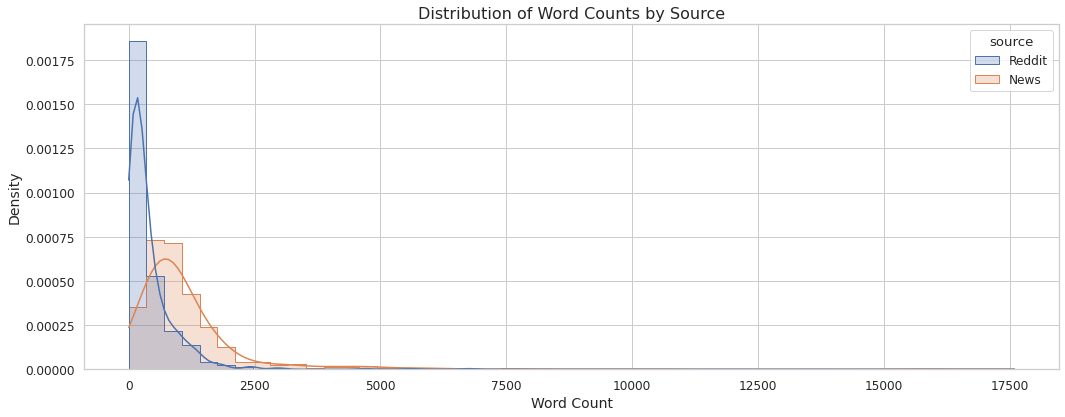

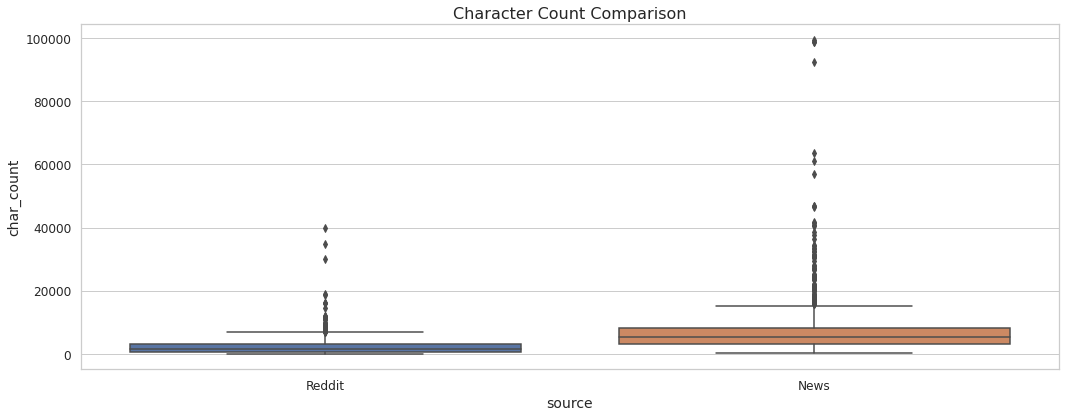

In [48]:
# Add new columns
df_comparison['text'] = df_comparison['text'].fillna('').astype(str)
df_comparison['char_count'] = df_comparison['text'].str.len()
df_comparison['word_count'] = df_comparison['text'].str.split().apply(len)

# Plot: Histogram of word counts
sns.histplot(data=df_comparison, x='word_count', hue='source', bins=50, kde=True, element='step', stat='density', common_norm=False)
plt.title('Distribution of Word Counts by Source')
plt.xlabel('Word Count')
plt.ylabel('Density')
plt.tight_layout()
plt.savefig('/home/leo/Images/Distribution of Word Counts by Source_ Histogram.png')
plt.show()

# Plot: Character counts
sns.boxplot(data=df_comparison, x='source', y='char_count')
plt.title('Character Count Comparison')
plt.tight_layout()
plt.savefig('/home/leo/Images/Distribution of Word Counts by Source_ Boxplot.png')
plt.show()


### Word Count Distribution by Source (Histogram)
This histogram compares the distribution of word counts between Reddit posts and News articles.

Both distributions are right-skewed, meaning most texts are relatively short, but there are a few very long entries.

Reddit posts tend to be much shorter and more tightly clustered around low word counts.

News articles, while still mostly short, show a wider spread and a longer right tail, indicating that some articles are significantly longer.

This pattern reflects the nature of each source: Reddit posts are user-generated and brief, while news articles often contain more detailed reporting.

### Character Count Comparison (Boxplot)
This boxplot compares the character lengths of text from each source.

News articles have a much higher median character count than Reddit posts, with a visibly larger interquartile range (IQR).

The News data also has more extreme outliers, further confirming the presence of very long articles while Reddit posts are more concise, with fewer outliers and a tighter distribution.

These visuals highlight how content length varies by platform, which could influence text modeling or topic extraction approaches later in the analysis.

### Word Count Comparison

For this, we shall get rid off outliers especially in news data to have a more accurate depitiction,since newspaper3k is not able to extract data from paywalled sites


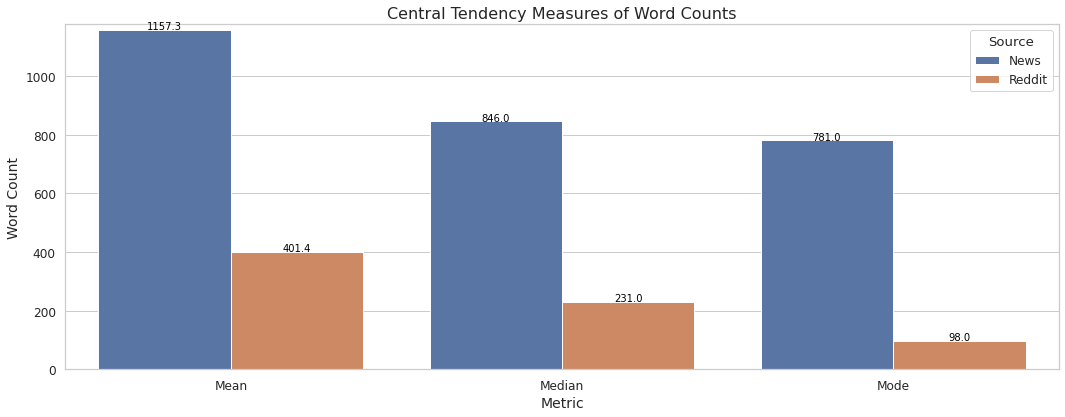

In [49]:
from scipy.stats import mode

# --- Compute word stats ---
def compute_word_stats(df, label):
    word_counts = df['text'].apply(lambda x: len(str(x).split()))
    return {
        'Source': label,
        'Mean': word_counts.mean(),
        'Median': word_counts.median(),
        'Mode': mode(word_counts).mode[0]
    }

# --- Get stats ---
news_stats = compute_word_stats(news_data_copy, 'News')
reddit_stats = compute_word_stats(reddit_data_copy, 'Reddit')

# --- Convert to DataFrame ---
stats_df = pd.DataFrame([news_stats, reddit_stats])
melted = stats_df.melt(id_vars='Source', var_name='Metric', value_name='Value')

# --- Plot ---
barplot = sns.barplot(data=melted, x='Metric', y='Value', hue='Source')

# --- Annotate values above bars ---
for p in barplot.patches:
    val = f'{p.get_height():.1f}'
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    barplot.text(x, y + 2, val, ha='center', fontsize=10, color='black')

plt.title('Central Tendency Measures of Word Counts')
plt.ylabel('Word Count')
plt.xlabel('Metric')
plt.ylim(0, melted['Value'].max() + 20)
plt.legend(title='Source')
plt.tight_layout()
plt.savefig('/home/leo/Images/Central Tendency Measures of Word Counts.png')
plt.show()


## Interpretation of Word Count Statistics

News articles tend to be significantly longer, with a mean word count of 1157 and a median of 846. This indicates that most articles are quite detailed, though a few very long ones pull the average up. The mode of 781 suggests a common length for many articles.

In contrast, Reddit posts are much shorter, with a mean of 401 and a median of 231. The low mode of 98 shows that many posts are very brief, which aligns with the conversational and informal nature of Reddit.


### 4.4 Most Common Words and Phrases

We will explore the most frequently used words in both Reddit posts and news articles. First, we look at individual words (unigrams), and then move to word pairs (bigrams), in order to get  an idea of the common vocabulary used in each source.


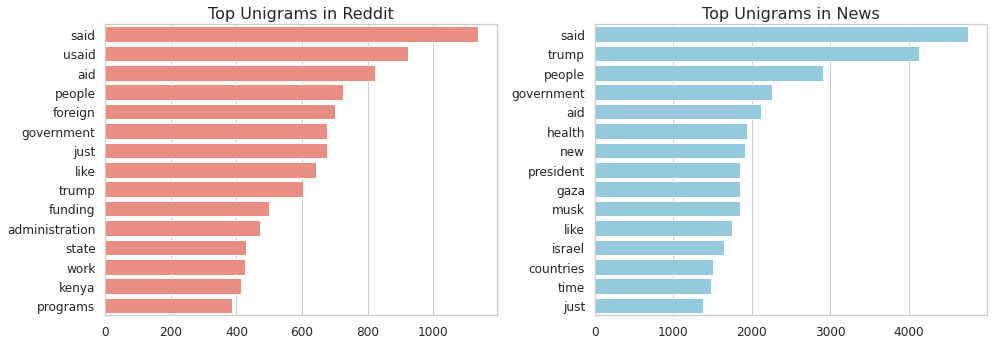

In [50]:
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer

# Separate texts by source
reddit_texts = reddit_data_copy['text'].fillna("")
news_texts = news_data_copy['text'].fillna("")

# Function to get top N unigrams
def get_top_unigrams(texts, n=15):
    vectorizer = CountVectorizer(stop_words='english')
    X = vectorizer.fit_transform(texts)
    word_counts = X.sum(axis=0).A1
    vocab = vectorizer.get_feature_names_out()
    freq_dist = dict(zip(vocab, word_counts))
    return Counter(freq_dist).most_common(n)

# Get top unigrams
reddit_unigrams = get_top_unigrams(reddit_texts)
news_unigrams = get_top_unigrams(news_texts)

# Plot
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Reddit
sns.barplot(x=[count for word, count in reddit_unigrams],
            y=[word for word, count in reddit_unigrams],
            ax=axes[0], color='salmon')
axes[0].set_title('Top Unigrams in Reddit')

# News
sns.barplot(x=[count for word, count in news_unigrams],
            y=[word for word, count in news_unigrams],
            ax=axes[1], color='skyblue')
axes[1].set_title('Top Unigrams in News')

plt.tight_layout()
plt.show()


### Bigram

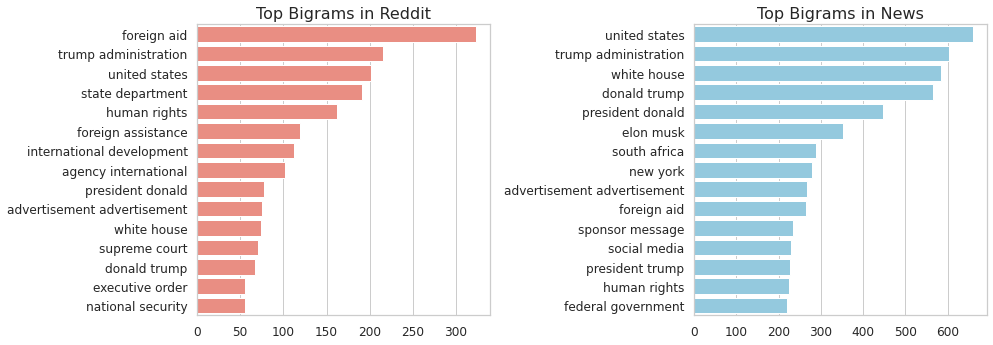

In [51]:
# Function to get top N bigrams
def get_top_bigrams(texts, n=15):
    vectorizer = CountVectorizer(ngram_range=(2, 2), stop_words='english')
    X = vectorizer.fit_transform(texts)
    bigram_counts = X.sum(axis=0).A1
    bigrams = vectorizer.get_feature_names_out()
    freq_dist = dict(zip(bigrams, bigram_counts))
    return Counter(freq_dist).most_common(n)

# Get top bigrams
reddit_bigrams = get_top_bigrams(reddit_texts)
news_bigrams = get_top_bigrams(news_texts)

# Plot
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Reddit
sns.barplot(x=[count for phrase, count in reddit_bigrams],
            y=[phrase for phrase, count in reddit_bigrams],
            ax=axes[0], color='salmon')
axes[0].set_title('Top Bigrams in Reddit')

# News
sns.barplot(x=[count for phrase, count in news_bigrams],
            y=[phrase for phrase, count in news_bigrams],
            ax=axes[1], color='skyblue')
axes[1].set_title('Top Bigrams in News')

plt.tight_layout()
plt.show()


- not much important info can be drawn from the above

## 4.5 Sentiment Analysis with VADER

We apply sentiment analysis to Reddit and News posts using the VADER sentiment analyzer. 
This gives us polarity scores for each text, helping us compare emotional between the sources.


In [52]:
# Import VADER
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Initialize analyzer
analyzer = SentimentIntensityAnalyzer()


### Apply VADER to Each Text Entry

We calculate sentiment scores (positive, neutral, negative, and compound) for every post or article.


In [53]:
# Function to apply VADER
def get_sentiment_scores(text):
    if pd.isna(text):
        return pd.Series([None, None, None, None])
    scores = analyzer.polarity_scores(text)
    return pd.Series([scores['neg'], scores['neu'], scores['pos'], scores['compound']])

# Apply to both datasets
sentiment_scores = df_comparison['text'].apply(get_sentiment_scores)

# Add sentiment columns
df_comparison[['neg', 'neu', 'pos', 'compound']] = sentiment_scores

# Display sample with sentiment
df_comparison[['source', 'text', 'compound']].head()


,source,text,compound
0,Reddit,someone on a different group different website...,-0.7695
1,Reddit,the classism i'm seeing in both subs is a good...,-0.9219
2,Reddit,are you still in contact with the organisation...,0.2693
3,Reddit,"i don't care what good book you read, but it's...",-0.9953
4,Reddit,how is kenya prepared to fill the vacuum of us...,0.2263



Plot the distribution of compound sentiment scores to compare Reddit and News.


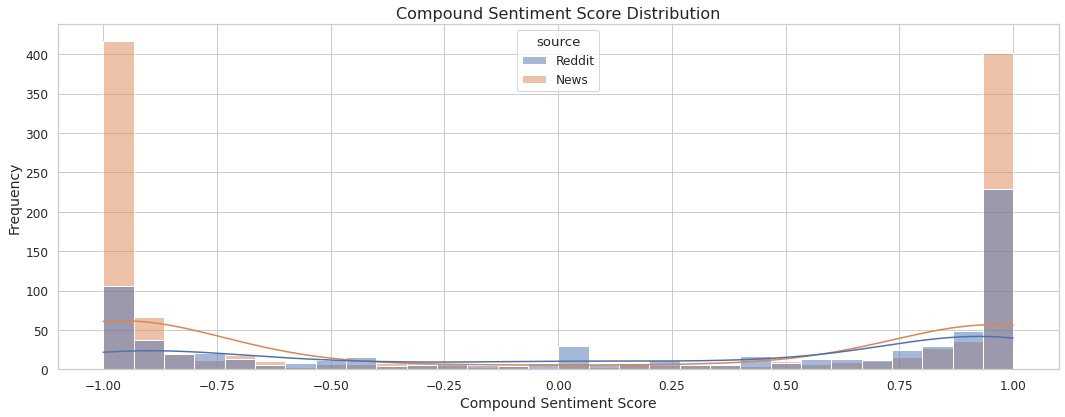

In [58]:


sns.histplot(data=df_comparison, x='compound', hue='source', kde=True, bins=30)
plt.title('Compound Sentiment Score Distribution')
plt.xlabel('Compound Sentiment Score')
plt.ylabel('Frequency')
plt.tight_layout()
plt.savefig('/home/leo/Images/Compound Sentiment Score Distribution.png')
plt.show()


## Sentiment Analysis – Compound Score Distribution

To understand the emotional tone of the text data, we used the **compound score** generated by VADER, which ranges from -1 (most negative) to +1 (most positive) and visualized the distribution of compound scores separately for Reddit and News articles to observe how sentiment varies across sources.

### Reddit Sentiment Distribution

For Reddit data:
- There is a **clear peak at +1.0** with around **225 entries**, indicating a large number of strongly positive posts.
- On the opposite end, there's a **smaller peak at -1.0** with about **100 entries**, suggesting fewer strongly negative posts.
- There is a **small but noticeable peak around 0.00** (neutral sentiment) with about **25 entries**.
- Between these peaks, the distribution is **approximately bell-shaped**, gradually tapering off from the extremes toward the center.

This suggests that Reddit discussions around the topic tend to be **polarized**, with a significant number of **strongly opinionated posts**, especially on the positive side.

### News Sentiment Distribution

For News articles:
- There are two **prominent peaks**—one near **-1.0 (about 420 entries)** and the other near **+1.0 (about 400 entries)**.
- The trough at **0.00** (neutral) is minimal, with very few entries.
- There is **no major central peak**, unlike Reddit, indicating that most articles are either clearly negative or clearly positive.

This likely reflects the nature of news reporting, especially on sensitive topics like **USAID funding cuts**—which tend to trigger **strongly framed narratives** either supporting or criticizing the development.

### Interpretation in Context

Given that the data collection was centered around **USAID funding cuts or withdrawals**, the sentiment spikes at both ends are understandable:
- **In News**, the dual peaks suggest **bipartisan or polarized reporting**, with some sources framing the funding cuts positively (e.g., efficiency, policy change), and others negatively (e.g., harming development or aid efforts).
- **In Reddit**, the stronger peak at **+1.0** could indicate **community support or optimism**, perhaps from discussions about self-reliance or alternative funding models. Meanwhile, the **-1.0 peak** captures **concern or outrage**, possibly over negative consequences.





## 4.7 Topic Modeling on Strongly Polarized Texts

To go beyond sentiment polarity and understand what people are talking about, we apply topic modeling.  
We focus on the most extreme posts:
- **Strongly Positive** (compound ≥ 0.6)
- **Strongly Negative** (compound ≤ -0.6)

We use the following NLP pipeline:
1. Filter texts by polarity
2. Preprocess text (tokenization, stopword removal, etc.)
3. Apply TF-IDF to identify key terms
4. Run LDA to discover latent topics

LDA assumes that each document (post or article) is a mixture of a small number of topics, and each topic is a mixture of words. It helps us identify **hidden thematic structures** in large text corpora.

### Why LDA was chosen

- It is useful when dealing with **unlabeled data**, as it doesn’t require predefined categories.
- Especially helpful for **exploring dominant themes** in positive and negative texts separately.

In this section, we will:

This allows us to uncover themes that drive strong emotional responses in Reddit and News content.


### 4.7 Topic Modeling on Strongly Positive and Negative Posts

To dive deeper into *why* people express strong sentiments, we applied **Latent Dirichlet Allocation (LDA)** — a popular topic modeling technique that discovers hidden thematic structures in text.

Using preprocessed strongly positive (`compound >= 0.6`) and strongly negative (`compound <= -0.6`) posts from both Reddit and News sources, we extracted key themes by:
- Converting text into TF-IDF vectors to emphasize informative words,
- Fitting LDA with 3 topics each for positive and negative subsets,
- Displaying the top 10 keywords in each discovered topic.

This allows us to interpret not only the **sentiment direction**, but also the **content focus** of each sentiment category.


In [55]:
df_comparison.columns

Index(['Unnamed: 0', 'title', 'text', 'subreddit', 'created_date', 'keyword',
       'is_future_date', 'language', 'text_translated', 'source',
       'published_date', 'full_text', 'mentions_kenya', 'word_count',
       'char_count', 'neg', 'neu', 'pos', 'compound'],
      dtype='object')

In [56]:
import nltk
import string
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# Download stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# --- Preprocessing Function ---
def preprocess(text):
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    tokens = text.split()
    tokens = [t for t in tokens if t not in stop_words and len(t) > 2]
    return ' '.join(tokens)

# --- Vectorization & LDA Function ---
def vectorize_and_lda(text_series, n_topics=3):
    vectorizer = TfidfVectorizer(max_df=0.95, min_df=5, stop_words='english')
    tfidf_matrix = vectorizer.fit_transform(text_series)
    lda_model = LatentDirichletAllocation(n_components=n_topics, random_state=42)
    lda_model.fit(tfidf_matrix)
    return lda_model, vectorizer.get_feature_names_out()

# --- Topic Display Function ---
def print_topics(model, feature_names, n_top_words=10):
    for idx, topic in enumerate(model.components_):
        top_words = [feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]
        print(f"Topic #{idx + 1}: {' | '.join(top_words)}")

# --- Separate Reddit and News ---
reddit_df = df_comparison[(df_comparison['source'] == 'Reddit') & (df_comparison['language'] == 'en')]
news_df = df_comparison[(df_comparison['source'] == 'News') & (df_comparison['language'] == 'en')]

# --- Preprocess & Filter ---
reddit_pos = reddit_df[reddit_df['compound'] >= 0.6]['text'].dropna().apply(preprocess)
reddit_neg = reddit_df[reddit_df['compound'] <= -0.6]['text'].dropna().apply(preprocess)

news_pos = news_df[news_df['compound'] >= 0.6]['full_text'].dropna().apply(preprocess)
news_neg = news_df[news_df['compound'] <= -0.6]['full_text'].dropna().apply(preprocess)

# --- LDA for Reddit ---
print("### Reddit - Strongly Positive Topics ###\n")
lda_rpos, feat_rpos = vectorize_and_lda(reddit_pos)
print_topics(lda_rpos, feat_rpos)

print("\n### Reddit - Strongly Negative Topics ###\n")
lda_rneg, feat_rneg = vectorize_and_lda(reddit_neg)
print_topics(lda_rneg, feat_rneg)

# --- LDA for News ---
print("\n### News - Strongly Positive Topics ###\n")
lda_npos, feat_npos = vectorize_and_lda(news_pos)
print_topics(lda_npos, feat_npos)

print("\n### News - Strongly Negative Topics ###\n")
lda_nneg, feat_nneg = vectorize_and_lda(news_neg)
print_topics(lda_nneg, feat_nneg)


[nltk_data] Downloading package stopwords to /home/leo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Reddit - Strongly Positive Topics ###

Topic #1: like | kenya | know | people | ive | dont | love | job | time | need
Topic #2: usaid | aid | said | foreign | trump | government | development | administration | funding | programs
Topic #3: hundreds | mass | usa | guidance | whats | travel | google | informed | supply | experiences

### Reddit - Strongly Negative Topics ###

Topic #1: delivering | heavy | emotional | words | black | age | died | family | report | weeks
Topic #2: governance | examples | suicide | suffer | words | caught | dangerous | subject | friends | convoy
Topic #3: usaid | said | people | aid | kenya | government | foreign | like | state | funding

### News - Strongly Positive Topics ###

Topic #1: said | trump | musk | people | government | health | like | new | federal | says
Topic #2: opens | click | window | copper | curious | facebook | brain | flows | share | whatsapp
Topic #3: israel | confidence | gates | pakistan | gaza | israeli | ceasefire | countries

- topic modeling skewed by Articles that could 

In [57]:
df_comparison.columns

Index(['Unnamed: 0', 'title', 'text', 'subreddit', 'created_date', 'keyword',
       'is_future_date', 'language', 'text_translated', 'source',
       'published_date', 'full_text', 'mentions_kenya', 'word_count',
       'char_count', 'neg', 'neu', 'pos', 'compound'],
      dtype='object')

## Topic Modeling Interpretation

LDA revealed distinct themes within strongly positive and negative sentiment groups across Reddit and News data.

### Key Strength
- LDA helps uncover hidden themes in text, providing useful insight into public sentiment and discourse focus. e.g topics  like governance, health and suffer appear 

### Weaknesses
- Topics can overlap or be vague (e.g., frequent words like "said", "people").
- Interpretation requires subjective judgment and may not capture full context.


## Applying BERT

In [ ]:
from bertopic import BERTopic
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
import nltk
import string
from nltk.corpus import stopwords

# Download stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# --- Preprocessing Function ---
def preprocess(text):
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    tokens = text.split()
    tokens = [t for t in tokens if t not in stop_words and len(t) > 2]
    return ' '.join(tokens)

# --- BERTopic Function ---
def extract_topics(text_series, n_topics=None):
    text_series = text_series.dropna().tolist()
    topic_model = BERTopic(top_n_words=10, nr_topics=n_topics, calculate_probabilities=False, verbose=False)
    topics, _ = topic_model.fit_transform(text_series)
    return topic_model

# --- Separate Reddit and News ---
reddit_df = df_comparison[(df_comparison['source'] == 'Reddit') & (df_comparison['language'] == 'en')]
news_df = df_comparison[(df_comparison['source'] == 'News') & (df_comparison['language'] == 'en')]

# --- Preprocess & Filter ---
reddit_pos = reddit_df[reddit_df['compound'] >= 0.6]['text'].dropna().apply(preprocess)
reddit_neg = reddit_df[reddit_df['compound'] <= -0.6]['text'].dropna().apply(preprocess)

news_pos = news_df[news_df['compound'] >= 0.6]['full_text'].dropna().apply(preprocess)
news_neg = news_df[news_df['compound'] <= -0.6]['full_text'].dropna().apply(preprocess)

# --- BERTopic for Reddit ---
print("### Reddit - Strongly Positive Topics ###\n")
topic_model_rpos = extract_topics(reddit_pos)
print(topic_model_rpos.get_topic_info().head())

print("\n### Reddit - Strongly Negative Topics ###\n")
topic_model_rneg = extract_topics(reddit_neg)
print(topic_model_rneg.get_topic_info().head())

# --- BERTopic for News ---
print("\n### News - Strongly Positive Topics ###\n")
topic_model_npos = extract_topics(news_pos)
print(topic_model_npos.get_topic_info().head())

print("\n### News - Strongly Negative Topics ###\n")
topic_model_nneg = extract_topics(news_neg)
print(topic_model_nneg.get_topic_info().head())


In [60]:
df_comparison.columns

Index(['Unnamed: 0', 'title', 'text', 'subreddit', 'created_date', 'keyword',
       'is_future_date', 'language', 'text_translated', 'source',
       'published_date', 'full_text', 'mentions_kenya', 'word_count',
       'char_count', 'neg', 'neu', 'pos', 'compound'],
      dtype='object')

# Conclusions and Recommendations

## Conclusions

The exploratory data analysis reveals clear distinctions between Reddit discussions and News articles related to USAID funding:

- **Text Length**: News articles are consistently longer than Reddit posts, both in word and character count. This aligns with the more formal, detailed nature of journalistic writing versus the brevity of social commentary.
  
- **Sentiment**: Both sources show **polarized sentiment distributions**, with prominent peaks at +1 and -1 compound scores. Reddit displays stronger positive sentiment overall, while News articles are more evenly split between positive and negative. Neutral sentiment is minimal in both.

- **Topic Modeling** (via LDA) uncovered broad themes like governance, health, and suffering. While helpful for general insights, LDA topics were sometimes vague or redundant.

- **Unigrams and Bigrams**: These n-gram analyses were less insightful, as common phrases (e.g., "Trump said", "people think") lacked thematic clarity or actionable value.

Overall, this suggests that public discourse around USAID funding—both in media and on Reddit—is emotionally charged and rich in polarized views, but varies significantly in length and language formality.

---

## Recommendations

To enhance the quality of future analysis:

- **Improve Source Diversity**: Broaden data collection to include a wider range of news outlets (including international ones) and Reddit communities to ensure a more balanced dataset.

- **Filter/Refine Text for N-grams**: Clean and preprocess n-grams more rigorously to remove high-frequency but low-value terms (e.g., named entities, boilerplate phrases) that obscure meaningful trends.

- **Use Domain-Specific Sentiment Models**: VADER is optimized for social media text; using models fine-tuned for news content could improve sentiment accuracy for journalistic text.

- **Topic Modeling Enhancements**:
  - Try alternative methods like BERTopic or Non-Negative Matrix Factorization (NMF) for sharper and more coherent topic extraction.
  - Use part-of-speech tagging to filter for nouns and adjectives, improving topic relevance.

- **Add Temporal Analysis**: If timestamp data is available, investigate how sentiment or topic frequency evolves over time—especially around key political events.

---

These insights and improvements will support more nuanced understanding of how different audiences and platforms engage with global development issues like USAID funding changes.


# Deployment
(https://public.tableau.com/app/profile/leonard.koyio/viz/USAIDSentimentAnalysis/Dashboard1)[https://public.tableau.com/app/profile/leonard.koyio/viz/USAIDSentimentAnalysis/Dashboard1]